In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from astropy import constants

from data_file import source_list_garrett, luminosity_list_barenfeld_updated, radius_dust_updated, lower_bound_radius_updated, upper_bound_radius_updated, flux_list_2_87mm_garrett, flux_barenfeld_0_88mm_updated
from Parallaxes import distances_updated_upper_sco
from Table_2 import surface_density_list
from Table_3 import opacity_list_3mm, opacity_list_0_87mm, temperature_list_van_der_plas


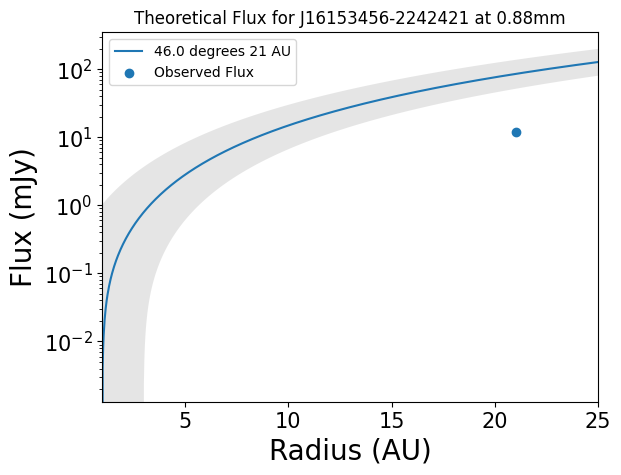

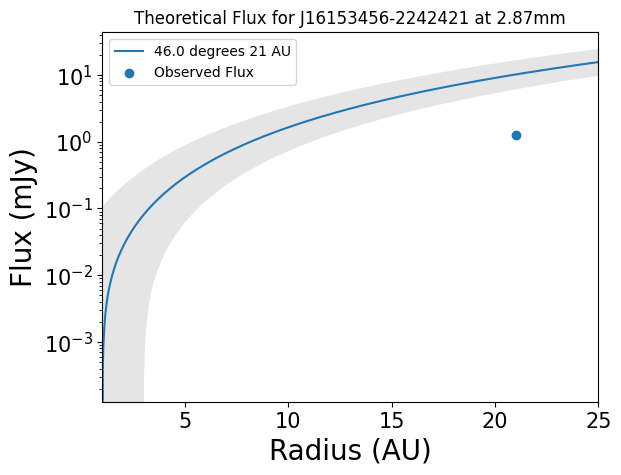

Flux at 21 AU: 85.12528387426885
Flux at 21 AU: 10.184849540194033


In [14]:

# All constants are in CGS units
wavelength_list = [0.088, 0.287]
c = constants.c.cgs.value
h = constants.h.cgs.value
k_b = constants.k_B.cgs.value
s_b = constants.sigma_sb.cgs.value
L_sun = constants.L_sun.cgs.value
c = constants.c.cgs.value

# Defining the star's name and finding its index in the data list
star_name = "J16153456-2242421"
index_star = source_list_garrett.index(star_name)

# Defining some values that can be changed to produce different results
flaring = 0.02
log_L_star = luminosity_list_barenfeld_updated[index_star]
L_star = (10 ** log_L_star) * L_sun
k_v_3mm = opacity_list_3mm[index_star]
k_v_0_87mm = opacity_list_0_87mm[index_star]
sur_den_0 = surface_density_list[index_star]

temperature_star = temperature_list_van_der_plas[index_star]
AU_in_cm = 1.5 * 10 ** 13
d = distances_updated_upper_sco[index_star] * AU_in_cm
R_in = 1 *AU_in_cm
R_out = radius_dust_updated[index_star] * AU_in_cm
R_out_list = np.linspace(1, 25, 1000) * AU_in_cm
R_out_lower_error = lower_bound_radius_updated[index_star] * AU_in_cm
R_out_upper_error = upper_bound_radius_updated[index_star] * AU_in_cm

# Defining the function to be integrated
function_to_integrate = lambda R, planck_function_wavelength: planck_function_wavelength * R


wavelength = 0.088
def planck_function_frequency(frequency, temperature):
    """
    Returns the Planck function at a given frequency and temperature.
    """
    exponent = h*frequency/(k_b*temperature)
    return 2*h*frequency**3/c**2 * 1/(np.exp(exponent)-1)

def integrated_planck_radius(R_in, R_out, temperature):
    """
    Integrates the Planck function multiplied by the radius from R_in to R_out.
    Returns the result in units of erg/s/cm^2.
    """
    function_to_integrate = lambda R, temperature: 4*np.pi*R**2*planck_function_frequency(c/wavelength, temperature)
    result, _ = quad(function_to_integrate, R_in, R_out, args=(temperature,))
    return result

def passive_T(R, L_star, flaring=0.02):
    T = (flaring * L_star / (8 * np.pi * R ** 2 * s_b)) ** (1/4)
    return T

def final(i, d, R_in, R_out, L_star):
    """
    Calculates the flux from the dust at a given inclination angle (i).
    """
    theoretical_flux = 2 * np.pi * np.cos(i) * integrated_planck_radius(R_in, R_out, passive_T(R_out, L_star, flaring=0.02)) / (d**2)
    return theoretical_flux

i = 46 * np.pi/180
i_lower_error = 21 * np.pi/180
i_upper_error = 12 * np.pi/180
# for i in radians from 'x' degrees i = x * np.pi/180
# for i in degrees from 'x' radians i = x * 180/np.pi

# Calculating the flux for the given inclination angle and radius
flux_values_0_88mm = []
flux_values_0_88mm_lower_error = []
flux_values_0_88mm_upper_error = []

flux_values_2_87mm = []
flux_values_2_87mm_lower_error = []
flux_values_2_87mm_upper_error = []

for radiuses in R_out_list:
    wavelength = 0.088
    flux_values_0_88mm.append(final(i, d, R_in, radiuses, L_star))
    flux_values_0_88mm_lower_error.append(final(i - i_lower_error, d, R_in, radiuses + R_out_upper_error, L_star))
    flux_values_0_88mm_upper_error.append(final(i + i_upper_error, d, R_in, radiuses + R_out_lower_error, L_star))
    wavelength = 0.287
    flux_values_2_87mm.append(final(i, d, R_in, radiuses, L_star))
    flux_values_2_87mm_lower_error.append(final(i - i_lower_error, d, R_in, radiuses + R_out_upper_error, L_star))
    flux_values_2_87mm_upper_error.append(final(i + i_upper_error, d, R_in, radiuses + R_out_lower_error, L_star))

i = i * 180/np.pi
i_lower_error = i_lower_error * 180/np.pi
i_upper_error = i_upper_error * 180/np.pi

if __name__ == '__main__':
    fig, ax = plt.subplots()
    plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm, label= str(i) + " degrees " + str(21) + " AU")
    #plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm_lower_error, label= str(i - i_lower_error) + " degrees " + str(21 + R_out_upper_error/AU_in_cm) + " AU")
    #plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm_upper_error, label= str(i + i_upper_error) + " degrees " + str(21 + R_out_lower_error/AU_in_cm) + " AU")
    plt.fill_between(R_out_list/AU_in_cm, flux_values_0_88mm_lower_error, flux_values_0_88mm_upper_error, alpha=0.2, facecolor='gray')
    plt.scatter(radius_dust_updated[index_star], flux_barenfeld_0_88mm_updated[index_star], label='Observed Flux')
    plt.xlim(1,25)

    plt.title("Theoretical Flux for J16153456-2242421 at 0.88mm")
    plt.xlabel("Radius (AU)", fontsize=20), plt.ylabel("Flux (mJy)", fontsize=20)
    plt.legend()
    plt.yscale('log')
    plt.savefig('J16153456-2242421 theoretical and measured flux 0.88mm.png')
    ax.tick_params(which='both', labelsize=15)


    plt.show()

    fig, ax = plt.subplots()
    plt.plot(R_out_list/AU_in_cm, flux_values_2_87mm, label= str(i) + " degrees " + str(21) + " AU")
    #plt.plot(R_out_list/AU_in_cm, flux_values_2_87mm_lower_error, label= str(i - i_lower_error) + " degrees " + str(21 + R_out_upper_error/AU_in_cm) + " AU")
    #plt.plot(R_out_list/AU_in_cm, flux_values_2_87mm_upper_error, label= str(i + i_upper_error) + " degrees " + str(21 + R_out_lower_error/AU_in_cm) + " AU")
    plt.fill_between(R_out_list/AU_in_cm, flux_values_2_87mm_lower_error, flux_values_2_87mm_upper_error, alpha=0.2, facecolor='gray')
    plt.scatter(radius_dust_updated[index_star], flux_list_2_87mm_garrett[index_star], label='Observed Flux')
    plt.xlim(1,25)

    plt.title("Theoretical Flux for J16153456-2242421 at 2.87mm")
    plt.xlabel("Radius (AU)", fontsize=20), plt.ylabel("Flux (mJy)", fontsize=20)
    plt.legend()
    plt.yscale('log')
    plt.savefig('J16153456-2242421 theoretical and measured flux 2.87mm.png')
    ax.tick_params(which='both', labelsize=15)

    plt.show()


i = 46 * np.pi/180
wavelength = 0.088
flux_21AU_0_88mm = final(i, d, R_in, 21 * AU_in_cm, L_star)
print('Flux at 21 AU:', flux_21AU_0_88mm)
wavelength = 0.287
flux_21AU_2_87mm = final(i, d, R_in, 21 * AU_in_cm, L_star)
print('Flux at 21 AU:', flux_21AU_2_87mm)

In [15]:
print(round(flux_barenfeld_0_88mm_updated[index_star]/flux_21AU_0_88mm * 100, 2), '%')
print(round(flux_list_2_87mm_garrett[index_star]/flux_21AU_2_87mm * 100, 2), '%')

13.8 %
12.37 %


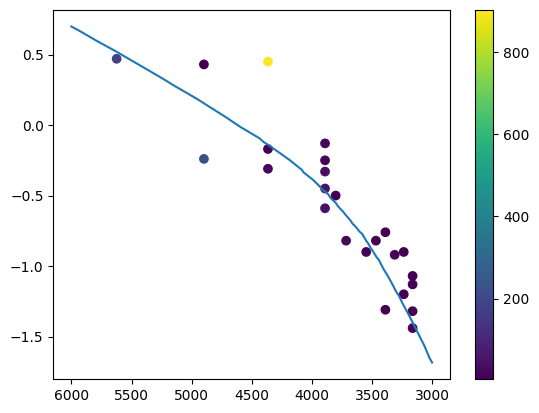

In [16]:
# create colorbar
# create scatter of stars spectral index vs flux_1mm
from data_file import temperature_list_barenfeld_updated
from Table_2 import spectral_index_upper_sco
from HR_Diagram import f10

temperature_list_barenfeld_updated = [10**x for x in temperature_list_barenfeld_updated]
plt.scatter(temperature_list_barenfeld_updated, luminosity_list_barenfeld_updated , c=flux_barenfeld_0_88mm_updated, label='Observed Flux')

x = np.linspace(3000, 6000, 1000)
plt.plot(x, f10(x), label='Spectral Index')

# calculate distance between each point and the line and store in a list
distance = []
for i in range(len(temperature_list_barenfeld_updated)):
    distance.append(abs((luminosity_list_barenfeld_updated[i] - f10(temperature_list_barenfeld_updated[i]))/np.sqrt(1 + f10(temperature_list_barenfeld_updated[i])**2)))

# normalize the distance list
distance = [x/max(distance) for x in distance]

plt.gca().invert_xaxis()
plt.colorbar()

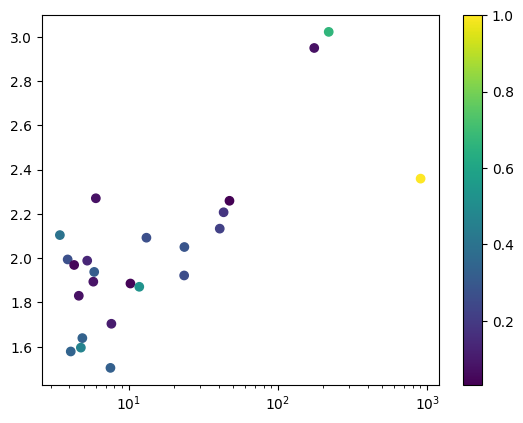

In [17]:
plt.scatter(flux_barenfeld_0_88mm_updated, spectral_index_upper_sco, c=distance)

plt.xscale('log')
plt.colorbar()

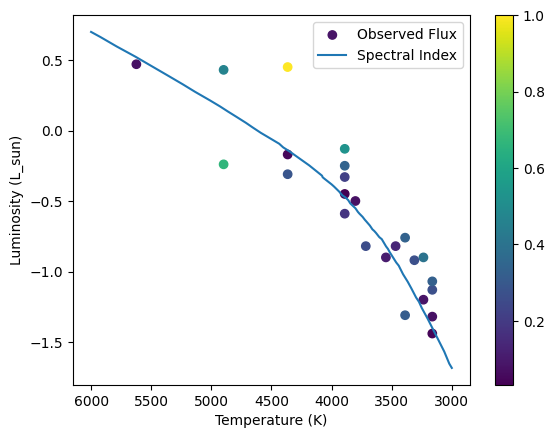

In [18]:
plt.scatter(temperature_list_barenfeld_updated, luminosity_list_barenfeld_updated , c=distance, label='Observed Flux')
plt.xlabel('Temperature (K)'), plt.ylabel('Luminosity (L_sun)')
plt.colorbar()
plt.gca().invert_xaxis()

x = np.linspace(3000, 6000, 1000)
plt.plot(x, f10(x), label='Spectral Index')
plt.legend()
plt.show()

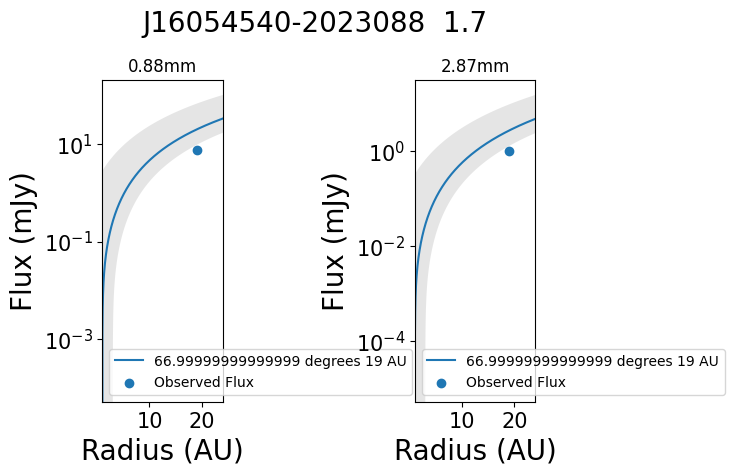

Flux 0.88mm at 21 AU: 19.80675147641737   38.57270592351531 %
Flux 2.87mm at 21 AU: 2.6914942124069214   37.154083237122414 %


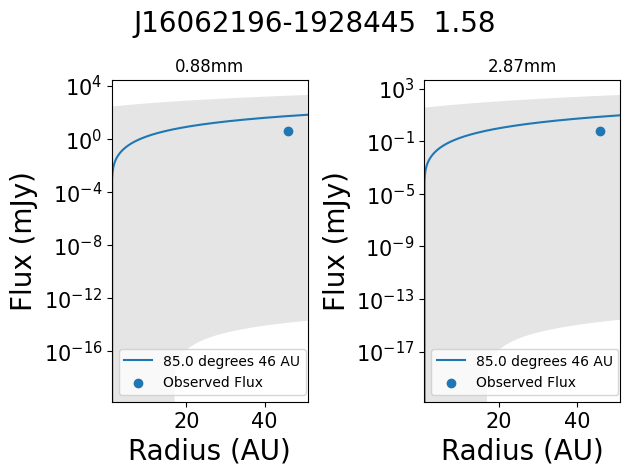

Flux 0.88mm at 21 AU: 51.54908426952607   7.914786572478352 %
Flux 2.87mm at 21 AU: 7.207068781005255   8.602665228255548 %


/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_2370/1025292114.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  T = (flaring * L_star / (8 * np.pi * R ** 2 * s_b)) ** (1/4)
/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_2370/1025292114.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*h*frequency**3/c**2 * 1/(np.exp(exponent)-1)


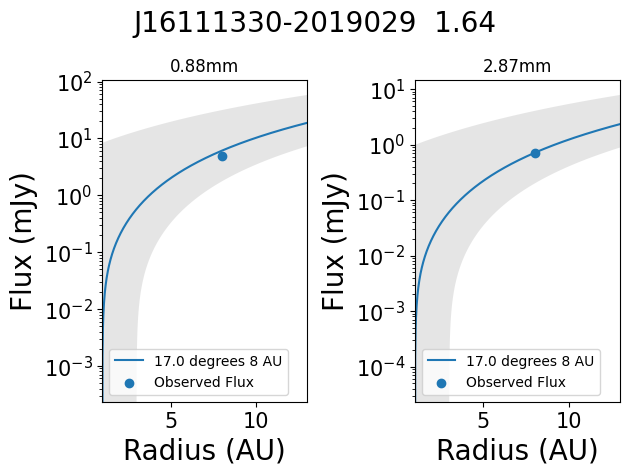

Flux 0.88mm at 21 AU: 6.094582687281384   80.07110987572516 %
Flux 2.87mm at 21 AU: 0.7084772104748615   97.39198238113022 %


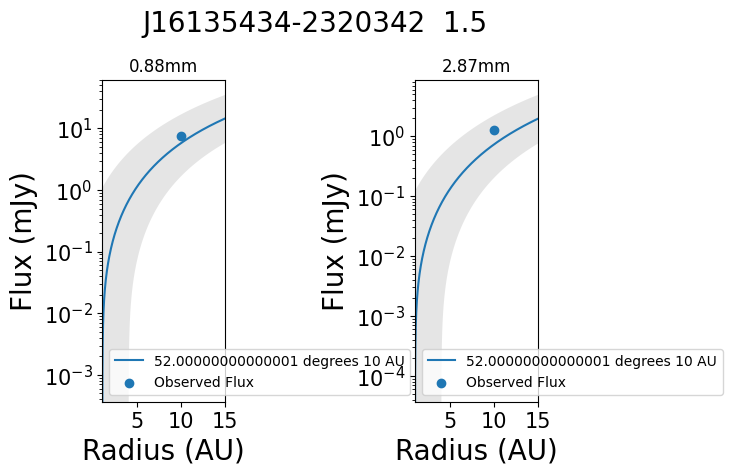

Flux 0.88mm at 21 AU: 5.80469158212173   129.7226543989377 %
Flux 2.87mm at 21 AU: 0.7287742798176939   171.52087204733584 %


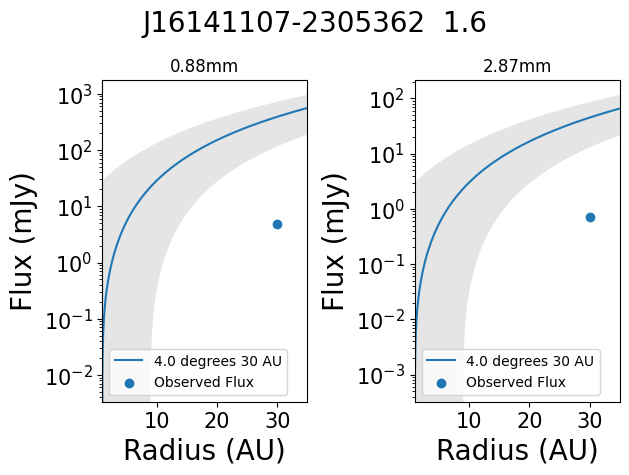

Flux 0.88mm at 21 AU: 390.5249993018784   1.2214326889513052 %
Flux 2.87mm at 21 AU: 45.15506241659324   1.572359691256001 %


/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_2370/1025292114.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  T = (flaring * L_star / (8 * np.pi * R ** 2 * s_b)) ** (1/4)
/var/folders/35/w3n1r1r17h7553z73jkyb2500000gn/T/ipykernel_2370/1025292114.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  return 2*h*frequency**3/c**2 * 1/(np.exp(exponent)-1)


In [23]:
from data_file import inclination_list_barenfeld_updated, inclination_list_barenfeld_lower_error_updated, inclination_list_barenfeld_upper_error_updated, lower_bound_radius_updated, upper_bound_radius_updated

from Table_2 import spectral_index_upper_sco

for index, element in enumerate(source_list_garrett):
    theoretical_flux_0_88mm = []
    theoretical_flux_0_88mm_lower_error = []
    theoretical_flux_0_88mm_upper_error = []
    theoretical_flux_2_87mm = []
    theoretical_flux_2_87mm_lower_error = []
    theoretical_flux_2_87mm_upper_error = []

    L_star = (10 ** luminosity_list_barenfeld_updated[index]) * L_sun
    i = inclination_list_barenfeld_updated[index] * np.pi/180
    i_lower_error = inclination_list_barenfeld_lower_error_updated[index] * np.pi/180
    i_upper_error = inclination_list_barenfeld_upper_error_updated[index] * np.pi/180
    d = distances_updated_upper_sco[index] * AU_in_cm

    R_out_list = np.linspace(1, radius_dust_updated[index] + 5, 1000) * AU_in_cm
    R_out_lower_error = lower_bound_radius_updated[index] * AU_in_cm
    R_out_upper_error = upper_bound_radius_updated[index] * AU_in_cm

    for radiuses in R_out_list:
        wavelength = 0.088
        theoretical_flux_0_88mm.append(final(i, d, R_in, radiuses, L_star))
        theoretical_flux_0_88mm_lower_error.append(final(i + i_lower_error, d, R_in, radiuses + R_out_upper_error, L_star))
        theoretical_flux_0_88mm_upper_error.append(final(i + i_upper_error, d, R_in, radiuses + R_out_lower_error, L_star))
        wavelength = 0.287
        theoretical_flux_2_87mm.append(final(i, d, R_in, radiuses, L_star))
        theoretical_flux_2_87mm_lower_error.append(final(i + i_lower_error, d, R_in, radiuses + R_out_upper_error, L_star))
        theoretical_flux_2_87mm_upper_error.append(final(i + i_upper_error, d, R_in, radiuses + R_out_lower_error, L_star))


    if __name__ == '__main__':

        if spectral_index_upper_sco[index] < 1.8:
            fig, ax = plt.subplots(1, 2)

            # i from radians to degrees
            ax[0].plot(R_out_list/AU_in_cm, theoretical_flux_0_88mm, label= str(i * 180/np.pi) + " degrees " + str(radius_dust_updated[index]) + " AU")
            #plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm_lower_error, label= str(i - i_lower_error) + " degrees " + str(21 + R_out_upper_error/AU_in_cm) + " AU")
            #plt.plot(R_out_list/AU_in_cm, flux_values_0_88mm_upper_error, label= str(i + i_upper_error) + " degrees " + str(21 + R_out_lower_error/AU_in_cm) + " AU")
            ax[0].fill_between(R_out_list/AU_in_cm, theoretical_flux_0_88mm_lower_error, theoretical_flux_0_88mm_upper_error, alpha=0.2, facecolor='gray')
            ax[0].scatter(radius_dust_updated[index], flux_barenfeld_0_88mm_updated[index], label='Observed Flux')
            ax[0].set_xlim(1, radius_dust_updated[index] + 5)

            ax[0].set_title("0.88mm")
            ax[0].set_xlabel("Radius (AU)", fontsize=20), ax[0].set_ylabel("Flux (mJy)", fontsize=20)
            ax[0].legend()
            ax[0].set_yscale('log')
            #plt.savefig(element + ' theoretical and measured flux 0.88mm.png')
            ax[0].tick_params(which='both', labelsize=15)


            ax[1].plot(R_out_list/AU_in_cm, theoretical_flux_2_87mm, label= str(i * 180/np.pi) + " degrees " + str(radius_dust_updated[index]) + " AU")
            #plt.plot(R_out_list/AU_in_cm, flux_values_2_87mm_lower_error, label= str(i - i_lower_error) + " degrees " + str(21 + R_out_upper_error/AU_in_cm) + " AU")
            #plt.plot(R_out_list/AU_in_cm, flux_values_2_87mm_upper_error, label= str(i + i_upper_error) + " degrees " + str(21 + R_out_lower_error/AU_in_cm) + " AU")
            ax[1].fill_between(R_out_list/AU_in_cm, theoretical_flux_2_87mm_lower_error, theoretical_flux_2_87mm_upper_error, alpha=0.2, facecolor='gray')
            ax[1].scatter(radius_dust_updated[index], flux_list_2_87mm_garrett[index], label='Observed Flux')
            ax[1].set_xlim(1, radius_dust_updated[index] + 5)

            ax[1].set_title("2.87mm")
            ax[1].set_xlabel("Radius (AU)", fontsize=20), ax[1].set_ylabel("Flux (mJy)", fontsize=20)
            ax[1].legend()
            ax[1].set_yscale('log')
            #plt.savefig('J16153456-2242421 theoretical and measured flux 2.87mm.png')
            ax[1].tick_params(which='both', labelsize=15)

            plt.suptitle(str(source_list_garrett[index]) + "  " + str(round(spectral_index_upper_sco[index], 2)), fontsize=20)
            plt.tight_layout()
            plt.show()

            wavelength = 0.088
            theoretical_flux_0_88mm = final(i, d, R_in, radius_dust_updated[index] * AU_in_cm, L_star)
            print('Flux 0.88mm at 21 AU:', theoretical_flux_0_88mm, ' ', flux_barenfeld_0_88mm_updated[index]/theoretical_flux_0_88mm * 100, '%')

            wavelength = 0.287
            theoretical_flux_2_87mm = final(i, d, R_in, radius_dust_updated[index] * AU_in_cm, L_star)
            print('Flux 2.87mm at 21 AU:', theoretical_flux_2_87mm, ' ', flux_list_2_87mm_garrett[index]/theoretical_flux_2_87mm * 100, '%')
